# Drugs dataset

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay, plot_roc_curve
from sklearn.svm import SVC
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/odelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/odelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/odelia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/odelia/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/odelia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
df_train = pd.read_csv("data/drugsComTrain_raw.tsv", sep='\t', index_col=[0])
df_test = pd.read_csv("data/drugsComTest_raw.tsv", sep='\t', index_col=[0])

## Preliminary data exploration

In [3]:
df_train['length'] = list(map(lambda x: len(str(x).split()), df_train['review']))
df_test['length'] = list(map(lambda x: len(str(x).split()), df_test['review']))

In [4]:
# Merge train and test sets
df = pd.concat([df_train, df_test]).reset_index(drop=True)

### Removal of duplicates!

In [5]:
df = df.drop_duplicates(subset=["condition" ,"review", "rating"]).reset_index(drop=True)

In [6]:
df.drugName.value_counts()

Levonorgestrel                       2533
Etonogestrel                         2245
Ethinyl estradiol / norethindrone    1945
Phentermine                          1813
Ethinyl estradiol / norgestimate     1519
                                     ... 
Motofen                                 1
Dextrostat                              1
Oxymetholone                            1
Locoid Lipocream                        1
Fluorometholone                         1
Name: drugName, Length: 3199, dtype: int64

In [7]:
df.condition.value_counts()

Birth Control                                   19524
Depression                                       7113
Pain                                             5193
Anxiety                                          5091
Acne                                             4551
                                                ...  
Somatoform Pain Disorde                             1
Esophageal Spasm                                    1
Campylobacter Gastroenteritis                       1
Peyronie's Disease                                  1
105</span> users found this comment helpful.        1
Name: condition, Length: 916, dtype: int64

In [8]:
df.describe()

,rating,usefulCount,length
count,130285.000000,130285.000000,130285.000000
mean,6.997582,26.924059,84.258242
std,3.274199,35.135337,44.962225
min,1.000000,0.000000,1.000000
25%,5.000000,6.000000,48.000000
50%,8.000000,15.000000,84.000000
75%,10.000000,35.000000,126.000000
max,10.000000,1291.000000,1894.000000


In [9]:
# Convert rating from float to int

df.rating = df.rating.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130285 entries, 0 to 130284
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   drugName     130285 non-null  object
 1   condition    129091 non-null  object
 2   review       130285 non-null  object
 3   rating       130285 non-null  int64 
 4   date         130285 non-null  object
 5   usefulCount  130285 non-null  int64 
 6   length       130285 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 7.0+ MB


### 'Rating' column

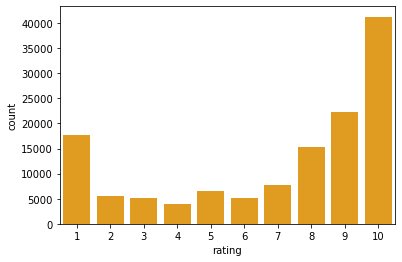

In [10]:
sns.countplot(df['rating'], color="orange")
plt.savefig('rating.png', transparent=True)

In [11]:
# data is skewed, imalanced towards positive ratings

In [12]:
rating = df.rating.value_counts(normalize=True).reset_index()
round(rating.rating, 2)

0    0.32
1    0.17
2    0.14
3    0.12
4    0.06
5    0.05
6    0.04
7    0.04
8    0.04
9    0.03
Name: rating, dtype: float64

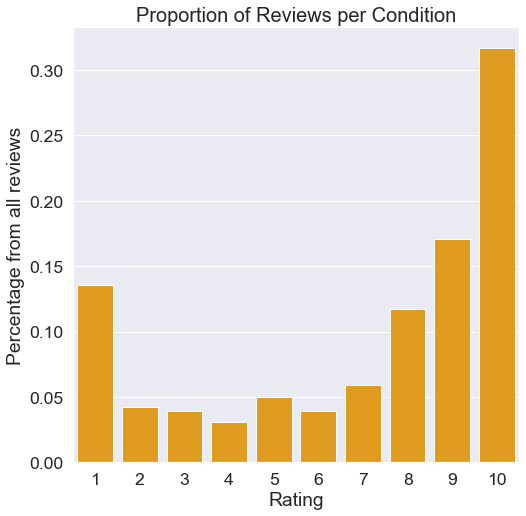

In [77]:
ax = sns.barplot(x=rating.iloc[:,0], y=rating.iloc[:,1], color="orange")
ax.set(xlabel='Rating', ylabel='Percentage from all reviews')
sns.set(style = 'darkgrid', font_scale = 1.6)
plt.rcParams['figure.figsize'] = [8, 8]
plt.title("Proportion of Reviews per Condition", fontsize = 20)
plt.savefig('rating.png', transparent=True)

### 'usefulCount' column

<AxesSubplot:xlabel='usefulCount', ylabel='count'>

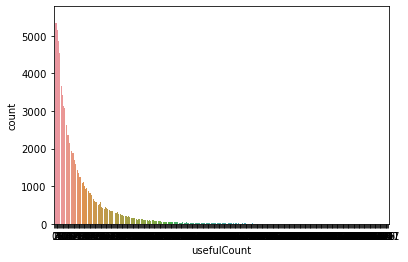

In [14]:
sns.countplot(df['usefulCount'])

<AxesSubplot:xlabel='usefulCount'>

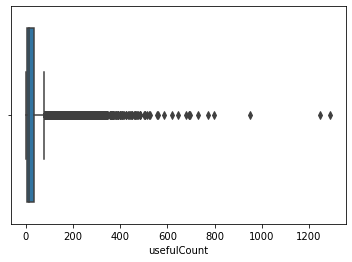

In [15]:
sns.boxplot(x=df['usefulCount'])

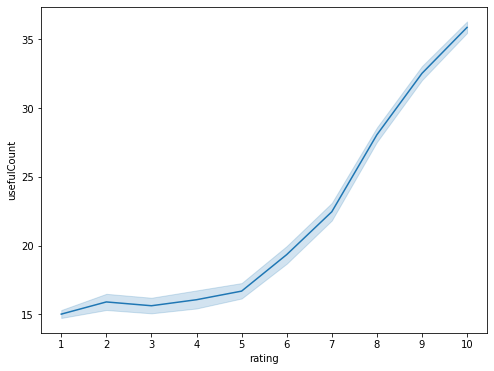

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
use_rating = sns.lineplot(x='rating',y='usefulCount',data=df)
ax.set_xticks(range(1,11))
plt.savefig('use_rating.png', transparent=True)

In [17]:
df['usefulCount'].describe()

count    130285.000000
mean         26.924059
std          35.135337
min           0.000000
25%           6.000000
50%          15.000000
75%          35.000000
max        1291.000000
Name: usefulCount, dtype: float64

In [18]:
df.loc[df['usefulCount'] == 0, 'usefulCount'].count()

5510

In [19]:
df.usefulCount.value_counts()

0      5510
3      5340
2      5332
1      5251
4      5156
       ... 
357       1
331       1
307       1
301       1
324       1
Name: usefulCount, Length: 397, dtype: int64

### General trends in the data

### [done] MARK PLOT

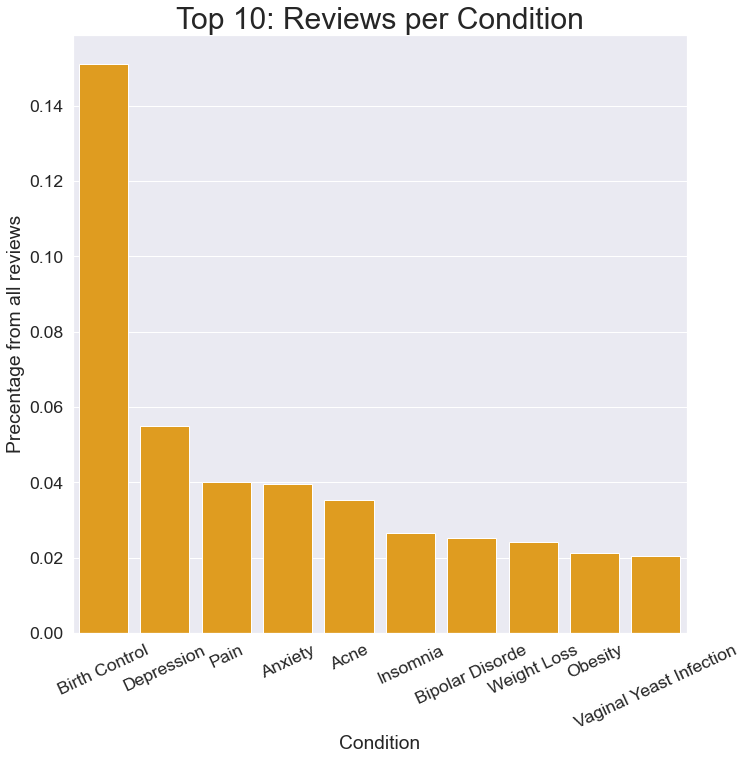

In [66]:
cond = dict(df['condition'].value_counts(normalize=True))
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.6)
plt.rcParams['figure.figsize'] = [11, 11]
plt.xticks(rotation=25)
sns_ = sns.barplot(x = top_condition, y = values, color="orange")
sns_.set_title("Top 10: Reviews per Condition", fontsize = 30)
sns_.set_xlabel("Condition")
sns_.set_ylabel("Precentage from all reviews");
plt.savefig('review_cond.png', transparent=True)

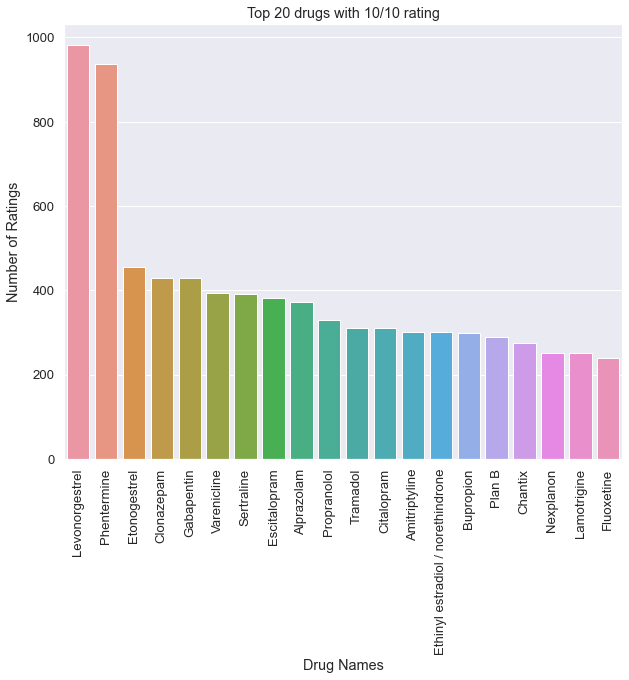

In [84]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

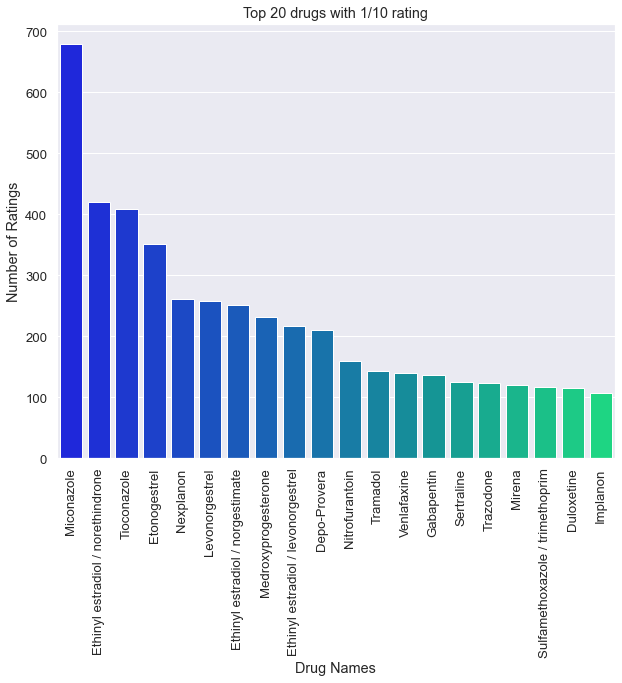

In [85]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

### MARK PLOT

Text(0.5, 1.0, 'Top 10 : Number of Drugs per Condition')

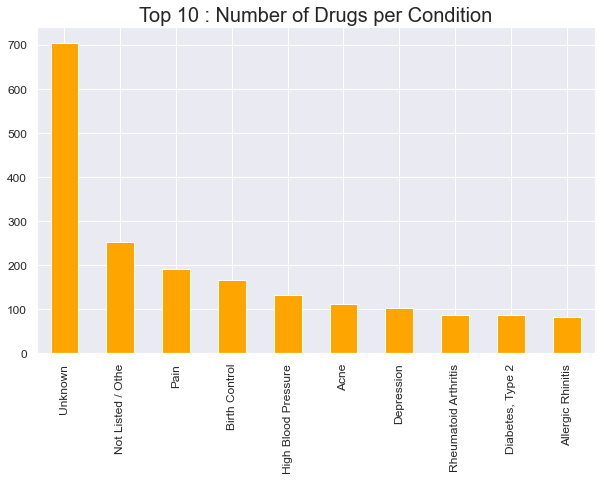

In [126]:

condition_dn = df.groupby(['condition_clean'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:10].plot(kind="bar", figsize = (10,6), fontsize = 12,color="orange")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
#plt.xticks(rotation=25)
plt.title("Top 10 : Number of Drugs per Condition", fontsize = 20)

## Data Cleaning

### Clean 'condition' column

In [87]:
df["condition_clean"] = df.condition.apply(lambda x: "Unknown" if str(x).__contains__("users found this comment helpful.") else x)

In [88]:
df.loc[df["condition_clean"] == "Unknown", "condition_clean"].count() 

1171

In [89]:
df["condition_clean"].apply(lambda x: str(x).lower()).nunique()

838

In [90]:
df.condition_clean.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       nan, 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'U

In [91]:
df["condition_clean"].nunique()

837

In [92]:
df["condition_clean"].isnull().sum()

1194

In [93]:
df["condition_clean"].fillna("Unknown", axis=0, inplace=True)
df

,drugName,condition,review,rating,date,usefulCount,length,condition_clean
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,"May 20, 2012",27,17,Left Ventricular Dysfunction
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192,141,ADHD
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,"December 14, 2009",17,134,Birth Control
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,"November 3, 2015",10,89,Birth Control
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,"November 27, 2016",37,124,Opiate Dependence
...,...,...,...,...,...,...,...,...
130280,Methadone,Pain,"""Have been taking it for 6 years (120 milligra...",10,"August 2, 2011",16,12,Pain
130281,Clomipramine,Panic Disorde,"""I&#039;ve been on clomipramine 15 years now a...",10,"February 19, 2013",28,49,Panic Disorde
130282,Levetiracetam,Epilepsy,"""I now suffer from excessive tiredness and lac...",8,"July 21, 2016",5,20,Epilepsy
130283,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,"September 13, 2014",43,97,"Breast Cancer, Prevention"


In [95]:
df["condition_clean"].isnull().sum()

0

AttributeError: 'Rectangle' object has no property 'rotate'

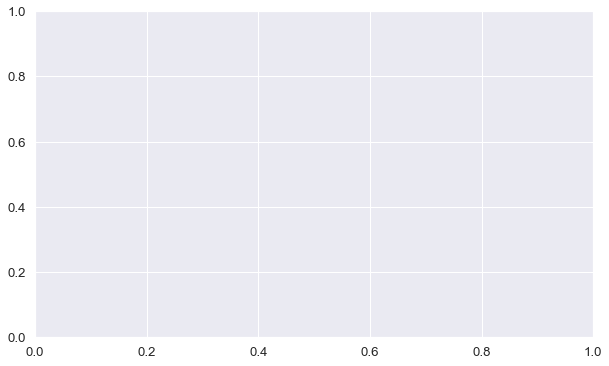

In [115]:
condition_dn = df.groupby(['condition_clean'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:10].plot(kind="bar", figsize = (10,6), fontsize = 15, color="orange", rotate=25)
#plt.xlabel("", fontsize = 15)
plt.ylabel("Count of Drugs", fontsize = 15)
plt.title("Top 10 : Number of Drugs per Condition", fontsize = 20)

### Clean reviews (inplace)

In [ ]:
df.drop(["date", "condition"], axis=1, inplace=True)

In [ ]:
df["condition_clean"].nunique()
df[df["condition_clean"] == "unknown"]

In [ ]:
condition_dn = df.groupby(['condition_clean'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="orange")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top 10 : Drug count per condition.", fontsize = 20)

In [ ]:
df["review"] = df.review.str.replace("&#039;", "")
df

In [ ]:
#lower casing
df.review = df.review.str.lower()

# Removing special Characters
#df.review = df.review.str.replace(r'[^\w\d\s]',' ')

# Removing all the non ASCII characters
df.review = df.review.str.replace(r'[^\x00-\x7F]+',' ')

# Removing the leading and trailing Whitespaces
#df.review = df.review.str.replace(r'^\s+|\s+?$','')
    
# Replacing multiple Spaces with Single Space
df.review = df.review.str.replace(r'\s+',' ')
    
# Replacing Two or more dots with one
df.review = df.review.str.replace(r'\.{2,}', ' ')

In [ ]:
df

In [ ]:
column_names = ["drugName", "condition_clean", "review", "usefulCount", "length", "rating"]
df_clean = df.reindex(columns=column_names)
df_clean

In [ ]:
# Exporting clean dataset with rating 1-10
df_clean.drop(["review"], axis=1).to_excel("data/df_no_dups_totableau.xlsx")

### Feature engineering: 'rating'

In [ ]:
df = df_clean
df

In [ ]:
df['rating'] = df.rating.apply(lambda x: 0 if x <= 6 else 1)
df

In [ ]:
df['rating'].value_counts()

## Creating the Corpus

In [ ]:
reviews = ['']
corpus=[]
for review in df['review']:
    reviews.append(review)
    corpus.append(nltk.sent_tokenize(review))
corpus

In [ ]:
len(corpus)

In [ ]:
corpus=[sent for sublist in corpus for sent in sublist]
corpus

In [ ]:
len(corpus)

### Cleaning corpus

In [ ]:
for i in range(len(corpus)):
    corpus[i] = re.sub(r'\d+','', corpus[i]) # Replace one or more digits by  ' '
    corpus[i] = re.sub(r"\s*'\s*\w*"," ", corpus[i])
    corpus[i] = re.sub(r'\W+',' ',corpus[i]) # Replace everything non-alpahnumeric by ' '
    corpus[i] = re.sub(r'\s+',' ', corpus[i]) # Replace one or more whitespaces by  ' '    
    corpus[i] = re.sub(r'^\s+|\s+?$','', corpus[i])
corpus

In [ ]:
corpus_pre_tok = corpus.copy()
corpus_pre_tok

In [ ]:
# Tokenizing the corpus

In [ ]:
wordfreq = {}
for sentence in corpus:
    words = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words:
        if ( word not in wordfreq.keys() ): ## first time appearnce in the sentence
            wordfreq[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq[word] += 1 # We increase the corresponding counter

In [ ]:
len(list(wordfreq.keys()))

In [ ]:
wordfreq

### Reducing the corpus

#### Stopwords

In [ ]:
from nltk.corpus import stopwords

stop_words = list(stopwords.words('english')) 
stop_words

In [ ]:
for i in range(len(stop_words)):
    stop_words[i] = re.sub(r"\s*'\s*\w*","",stop_words[i])
stop_words

In [ ]:
stop_words.extend(['im', 'ive', 'it', 'mg', 'quot'])
stop_words

In [ ]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]
corpus

In [ ]:
# Keeping 30 most preq words

corpus.sort(reverse = True)
corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

#### LIST 1 [FULL]

In [ ]:
cols = {word[0]: [] for word in corpus_freq}
reviews = pd.DataFrame(cols)

reviews.columns

In [ ]:
def review_inpector(sentence, stop_words, words):

    import re

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Cleanup the tokenp
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Dropping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

In [ ]:
my_list = list(map(review_inpector, df['review'], 
                    [stop_words]*df.shape[0], [list(cols.keys())]*df.shape[0] ) )

my_list[:2]

In [ ]:
reviews = pd.DataFrame(my_list)

In [ ]:
reviews

In [ ]:
reviews['rating'] = df['rating'].reset_index(drop=True)
reviews

#### LIST 3: stopwords incl. negation

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))
exclude_words = set(("aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"))
new_stop_words = stop_words.difference(exclude_words)

In [ ]:
new_stop_words = list(new_stop_words)

In [ ]:
new_stop_words.extend(['im', 'ive', 'it', 'mg', 'quot'])
new_stop_words

In [ ]:
for i in range(len(new_stop_words)):
    new_stop_words[i] = re.sub(r"\s*'\s*\w*","",new_stop_words[i])
new_stop_words

In [ ]:
corpus4 = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in new_stop_words]
corpus4

In [ ]:
corpus4.sort(reverse = True)
corpus_freq4 = [(word[1],word[0]) for word in corpus4[:31]] 
corpus_freq4 = corpus_freq4[1:]
corpus_freq4

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

# Modeling (FULL SAMPLE)

### Cross-validation?

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## Running the RanFor Model with n-grams

In [ ]:
X = reviews.drop(columns='rating')
y = reviews['rating']
X
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

y_train = pd.DataFrame(y_train, columns =['rating'])
y_test  = pd.DataFrame(y_test, columns =['rating'])

In [ ]:
X_train
#y_train

In [ ]:
y_test.value_counts()

In [ ]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train['rating'])

### Making predictions with RF

In [ ]:
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

In [ ]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Model performance

In [ ]:
model_performance_class(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

#### Tuning the hyper paramters with gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [ ]:
#grid_search.fit(X_train,y_train)

In [ ]:
#grid_search.best_params_

In [ ]:
## Rerunning model

In [ ]:
clf = RandomForestClassifier(max_depth=10, max_features="sqrt",n_estimators=50, min_samples_leaf =1, bootstrap=False ,random_state=42)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
from sklearn.model_selection import cross_val_score
#clf = RandomForestClassifier(random_state=42, max_features='sqrt', 
                             #min_samples_leaf=1, min_samples_split=2, n_estimators=100)
clf = RandomForestClassifier(max_depth=10, max_features="sqrt",n_estimators=50, min_samples_leaf =1, bootstrap=False ,random_state=42)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring="recall_samples")
print(np.mean(cross_val_scores))

In [ ]:
print(cross_val_scores)

#### Running the Naive Bayes model

In [ ]:
y_train
X_train

In [ ]:
#nb = CategoricalNB()
#nb.fit(X_train, y_train['rating'])

(Not) Making predictions with NB

In [ ]:
#y_train_pred_nb = nb.predict(X_train)
#y_test_pred_nb  = nb.predict(X_test)

Model performance

In [ ]:
#model_performance_class(y_train, y_train_pred_nb, y_test, y_test_pred_nb)

### SVC instead of NB

In [ ]:
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=42, tol=1e-2, max_iter=5000)

In [ ]:
svm.fit(X_train, y_train)

In [ ]:
y_train_pred_svm = svm.predict(X_train)
y_test_pred_svm  = svm.predict(X_test)

In [ ]:
model_performance_class(y_train, y_train_pred_svm, y_test, y_test_pred_svm)

In [ ]:
# terrible

## TF-IDF (Term-Frequency Inverse Document-Frequency)

### Dataset prep: re-cleaning reviews

In [ ]:
# Using Rafa's nice function from now on

def clean_review(x):
    x = str(x).lower().replace("\\","").replace("_"," ")
    x = re.sub(r'\W+',' ',x) # Replace everything non-alpahnumeric by ' '
    x = re.sub(r'\s+',' ',x) # Replace one or more whitespaces by  ' '
    x = re.sub(r'\d+',' ',x) # Replace one or more digits by  ' '
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", x) # Replace e-mails by ''
    # Replace urls by ''
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , x) 
    # Replace html tags by ''
    x = BeautifulSoup(x, 'html.parser').get_text().strip()
    x = x.replace(' br ',' ')

    return x

In [ ]:
reviews_cleaned = df.copy()

In [ ]:
reviews_cleaned = reviews_cleaned[['review','rating']]

In [ ]:
reviews_cleaned.head()

In [ ]:
reviews_cleaned['review'] = reviews_cleaned['review'].apply(lambda x: clean_review(x)) 

In [ ]:
reviews_cleaned

### >>> Running the TF-IDF model: uni + bigrams

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,2), analyzer = 'word',
                       stop_words = stop_words )

In [ ]:
X_TF = tidf.fit_transform(reviews_cleaned['review'])
y_TF = reviews_cleaned['rating']

In [ ]:
tidf.get_feature_names()

In [ ]:
tidf.get_feature_names_out(input_features=None)

In [ ]:
len(tidf.get_feature_names())

In [ ]:
X_TF[:2,:5]

#### Train test split

In [ ]:
X_TF_train, X_TF_test, y_TF_train, y_TF_test = train_test_split(X_TF, y_TF, test_size=0.20, random_state=42)

In [ ]:
type(X_TF_train)

#### Generating the model

In [ ]:
rf1 = RandomForestClassifier(max_depth=200, n_estimators=100)

y_TF_train = y_TF_train.astype('int')
y_TF_test  = y_TF_test.astype('int')

rf1.fit(X_TF_train, y_TF_train)

y_TF_train_pred_rf = rf1.predict(X_TF_train)
y_TF_test_pred_rf  = rf1.predict(X_TF_test)

#### Model performance

In [ ]:
model_performance_class(y_TF_train, y_TF_train_pred_rf, y_TF_test, y_TF_test_pred_rf)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

performance_df = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_TF_train, y_TF_train_pred_rf),
                                         precision_score(y_TF_train, y_TF_train_pred_rf),
                                         recall_score(y_TF_train, y_TF_train_pred_rf)],
                               'Test': [accuracy_score(y_TF_test, y_TF_test_pred_rf),
                                        precision_score(y_TF_test, y_TF_test_pred_rf),
                                        recall_score(y_TF_test, y_TF_test_pred_rf)]})

display(performance_df)

print("Confusion matrix for the train set")
print(confusion_matrix(y_TF_train,y_TF_train_pred_rf).T)
plot_confusion_matrix(rf1, X_TF_train, y_TF_train, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_TF_test,y_TF_test_pred_rf).T)
plot_confusion_matrix(rf1, X_TF_test,y_TF_test, values_format = 'd')
plt.show()

In [ ]:
# What's wrong with the confusion matrix??

In [ ]:
ax = sns.barplot(x="Error_metric", y="Test", data=performance_df)

## Forming LIST 1: POS tagging instead of stopwords

### Applying tags and filtering POS

In [ ]:
nltk.help.upenn_tagset()

### Tokenizing

In [ ]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN'] ):
            words.append(tag[0])
    return words[1:-1]

In [ ]:
list_filtered = filter_review(str(corpus_pre_tok))

In [ ]:
len(list_filtered)

### Reducing the list

In [ ]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]
stop_words

In [ ]:
corpus.sort(reverse = True)

corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq

In [ ]:
# exact same set as without POS tagging and filtering... no need to re-run models.

# DOWNSAMPLE: to balance higher num of high rating

In [ ]:
reviews_cleaned

In [ ]:
# Splitting df 

category_0 = reviews_cleaned[reviews_cleaned['rating'] == 0]
category_1 = reviews_cleaned[reviews_cleaned['rating'] == 1]
category_1
category_0

In [ ]:
# Filtering df according to minority group 

category_1 = category_1.sample(len(category_0))
print(category_0.shape)
print(category_1.shape)

In [ ]:
# Putting together the two splits

df_down = pd.concat([category_0, category_1], axis=0)
df_down = df_down.sample(frac=1)
df_down['rating'].value_counts()
df_down.reset_index(drop=True, inplace=True)
df_down

### BOW

In [ ]:
reviews2 = ['']
corpus2=[]
for review in df_down['review']:
    reviews2.append(review)
    corpus2.append(nltk.sent_tokenize(review))
corpus2

In [ ]:
len(corpus2)

In [ ]:
corpus2=[sent for sublist in corpus2 for sent in sublist]
corpus2

In [ ]:
len(corpus2)

### Cleaning corpus

In [ ]:
for i in range(len(corpus2)):
    corpus2[i] = re.sub(r'\d+','', corpus2[i]) # Replace one or more digits by  ' '
    corpus2[i] = re.sub(r"\s*'\s*\w*"," ", corpus2[i])
    corpus2[i] = re.sub(r'\W+',' ',corpus2[i]) # Replace everything non-alpahnumeric by ' '
    corpus2[i] = re.sub(r'\s+',' ', corpus2[i]) # Replace one or more whitespaces by  ' '    
    corpus2[i] = re.sub(r'^\s+|\s+?$','', corpus2[i])
corpus2

In [ ]:
corpus2_pre_tok = corpus2.copy()
corpus2_pre_tok

### POS

In [ ]:
nltk.help.upenn_tagset()

In [ ]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN'] ):
            words.append(tag[0])
    return words[1:-1]

In [ ]:
list_filtered2 = filter_review(str(corpus2_pre_tok))

In [ ]:
len(list_filtered2)

In [ ]:
list_filtered2

### Reducing the corpus

#### Stopwords

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))
exclude_words = set(("aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"))
stop_words = stop_words.difference(exclude_words)
stop_words = list(stop_words)

In [ ]:
for i in range(len(stop_words)):
    stop_words[i] = re.sub(r"\s*'\s*\w*","",stop_words[i])
stop_words

In [ ]:
stop_words.extend(['im', 'ive', 'it', 'mg', 'quot'])
stop_words

In [ ]:
# Matching with frequencies?

In [ ]:
wordfreq2 = {}
for word in list_filtered2:
    if ( word not in wordfreq2.keys() ): ## first time appearnce in the sentence
        wordfreq2[word] = 1 # We initialize the corresponding counter
    else: ## if the world is already existed in the dictionalry 
        wordfreq2[word] += 1 # We increase the corresponding counter

In [ ]:
list_filtered_again = [(wordfreq2[key],key) for key in list(wordfreq2.keys()) if key not in stop_words]
list_filtered_again

In [ ]:
len(list(wordfreq2.keys()))

In [ ]:
list_filtered_again.sort(reverse = True)
corpus_freq2 = [(word[1],word[0]) for word in list_filtered_again[:31]] 
corpus_freq2 = corpus_freq2[1:]
corpus_freq2

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq2 = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq2]
corpus_freq2

In [ ]:
cols2 = {word[0]: [] for word in corpus_freq2}
reviews2 = pd.DataFrame(cols2)

reviews2

In [ ]:
cols2

In [ ]:
stop_words

In [ ]:
my_list2 = list(map(review_inpector, df_down['review'], 
                    [stop_words]*df.shape[0], [list(cols2.keys())]*df.shape[0] ) )

my_list2[:2]

In [ ]:
reviews2 = pd.DataFrame(my_list2)

In [ ]:
reviews2

In [ ]:
reviews2['rating'] = df_down['rating'].reset_index(drop=True)
reviews2

## Modeling (DOWNSAMPLE)

### Cross-validation?

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## >>> Running the RanFor Model with BOW

In [ ]:
X2 = reviews2.drop(columns='rating')
y2 = reviews2['rating']
X2
y2

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=42)

X_train2 = pd.DataFrame(X_train2, columns=X2.columns)
X_test2  = pd.DataFrame(X_test2, columns=X2.columns)

y_train2 = pd.DataFrame(y_train2, columns =['rating'])
y_test2  = pd.DataFrame(y_test2, columns =['rating'])

In [ ]:
X_train2
y_train2
X_test2

In [ ]:
y_test2.value_counts()

In [ ]:
rf2 = RandomForestClassifier()

rf2.fit(X_train2, y_train2['rating'])

### Making predictions with RF

In [ ]:
y_train_pred_rf2 = rf2.predict(X_train2)
y_test_pred_rf2  = rf2.predict(X_test2)

In [ ]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Model performance

In [ ]:
model_performance_class(y_train2, y_train_pred_rf2, y_test2, y_test_pred_rf2)

#### Tuning the hyper paramters with gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [ ]:
grid_search.fit(X_train2,y_train2)

In [ ]:
grid_search.best_params_

In [ ]:
clf = RandomForestClassifier(bootstrap=False, max_depth=10,max_features="sqrt",n_estimators=100, min_samples_leaf = 2, random_state=42)
clf.fit(X_train2, y_train2)
print(clf.score(X_train2, y_train2))
print(clf.score(X_test2, y_test2))

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
cross_val_scores = cross_val_score(clf, X_train2, y_train2, cv=10)
print(np.mean(cross_val_scores))

## TF_IDF DOWNSAMPLE

### >>> With uni + bigrams

In [ ]:
df_down

In [ ]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,2), analyzer = 'word',
                       stop_words = stop_words, min_df=2 )

In [ ]:
X_TF2 = tidf.fit_transform(df_down['review'])
y_TF2 = df_down['rating']

In [ ]:
table = pd.DataFrame(X_TF2.toarray(), columns=features)

In [ ]:
list_score = []
for column in table.columns:
    list_score.append(table[column].mean())

In [ ]:
text_plot = pd.DataFrame({"feature": features, "score": list_score})
text_plot = text_plot.sort_values(by="score", ascending=False)
text_plot.iloc[-30:,:]

In [ ]:
features = tidf.get_feature_names()
features

In [ ]:
len(tidf.get_feature_names())

In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [ ]:
X_TF2[:2,:5]

#### Train test split

In [ ]:
X_TF_train2, X_TF_test2, y_TF_train2, y_TF_test2 = train_test_split(X_TF2, y_TF2, test_size=0.20, random_state=42)

In [ ]:
type(X_TF_train2)

#### Generating the model

In [ ]:
rf3 = RandomForestClassifier(max_depth=75, n_estimators=100)

y_TF_train2 = y_TF_train2.astype('int')
y_TF_test2  = y_TF_test2.astype('int')

rf3.fit(X_TF_train2, y_TF_train2)

y_TF_train_pred_rf2 = rf3.predict(X_TF_train2)
y_TF_test_pred_rf2  = rf3.predict(X_TF_test2)

#### Model performance

In [ ]:
model_performance_class(y_TF_train2, y_TF_train_pred_rf2, y_TF_test2, y_TF_test_pred_rf2)

In [ ]:
Xtr = TfidfVectorizer.fit_transform(X_TF2)
vec = TfidfVectorizer.named_steps['vec']
features = vec.get_feature_names()

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [ ]:
grid_search.fit(X_TF_train2,y_TF_train2)

In [ ]:
grid_search.best_params_

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

performance_df_best = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_TF_train2, y_TF_train_pred_rf2),
                                         precision_score(y_TF_train2, y_TF_train_pred_rf2),
                                         recall_score(y_TF_train2, y_TF_train_pred_rf2)],
                               'Test': [accuracy_score(y_TF_test2, y_TF_test_pred_rf2),
                                        precision_score(y_TF_test2, y_TF_test_pred_rf2),
                                        recall_score(y_TF_test2, y_TF_test_pred_rf2)]})

display(performance_df_best)

print("Confusion matrix for the train set")
print(confusion_matrix(y_TF_train2,y_TF_train_pred_rf2).T)
plot_confusion_matrix(rf3, X_TF_train2, y_TF_train2, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_TF_test2,y_TF_test_pred_rf2).T)
plot_confusion_matrix(rf3, X_TF_test2,y_TF_test2, values_format = 'd')
plt.show()

### >>> With bigrams only

In [ ]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (2,2), analyzer = 'word',
                       stop_words = stop_words, min_df=2 )

In [ ]:
X_TF_down_bi = tidf.fit_transform(df_down['review'])
y_TF_down_bi = df_down['rating']

#### Train test split

In [ ]:
X_TF_down_bi_train, X_TF_down_bi_test, y_TF_down_bi_train, y_TF_down_bi_test = train_test_split(X_TF_down_bi, y_TF_down_bi, test_size=0.20, random_state=42)

In [ ]:
type(X_TF_down_bi_train)

#### Generating the model

In [ ]:
rf4 = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_down_bi_train = y_TF_down_bi_train.astype('int')
y_TF_down_bi_test  = y_TF_down_bi_test.astype('int')

rf4.fit(X_TF_down_bi_train, y_TF_down_bi_train)

y_TF_down_bi_train_pred_rf = rf4.predict(X_TF_down_bi_train)
y_TF_down_bi_test_pred_rf  = rf4.predict(X_TF_down_bi_test)

#### Model performance

In [ ]:
model_performance_class(y_TF_down_bi_train, y_TF_down_bi_train_pred_rf, y_TF_down_bi_test, 
                        y_TF_down_bi_test_pred_rf)

#### Tuning the hyper paramters with gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [150, 200],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [ ]:
grid_search.fit(X_TF_train2,y_TF_train2)

In [ ]:
grid_search.best_params_

In [ ]:
#pd.DataFrame(grid_search.cv_results_)

In [ ]:
cross_val_scores = cross_val_score(clf, X_train2, y_train2, cv=10)
print(np.mean(cross_val_scores))

In [ ]:
metrics.RocCurveDisplay

In [ ]:
metrics.RocCurveDisplay.from_estimator

In [ ]:
# 1 - BOW, down
disp = plot_roc_curve(rf2, X_test2, y_test2, name="BOW, balanced", pos_label=0)
plt.gcf().set_size_inches(12,6)
#2 - TF-IDF down bi grams
plot_roc_curve(rf4, X_TF_down_bi_test, y_TF_down_bi_test, name="TF-IDF, balanced, bigrams", ax=disp.ax_, pos_label=0);

#3 - TF-IDF down uni/bi grams
plot_roc_curve(rf3, X_TF_test2, y_TF_test2, name="TF-IDF, balanced, uni+bigrams", ax=disp.ax_, pos_label=0);

#4 - TF-IDF full uni/bi grams
plot_roc_curve(rf1, X_TF_test, y_TF_test, name="TF-IDF, imbalanced, uni+bigrams", ax=disp.ax_, pos_label=0);
plt.plot([0, 1], [0, 1],'r--')
plt.savefig('demo.png', transparent=True)

In [ ]:
# Plot recall (chose green option as recall for cat 1 is better)

In [ ]:
performance_df1 = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               #'Train': [accuracy_score(y_TF_train, y_TF_train_pred_rf),
                                #         precision_score(y_TF_train, y_TF_train_pred_rf),
                                 #        recall_score(y_TF_train, y_TF_train_pred_rf)],
                               'Test': [accuracy_score(y_TF_test, y_TF_test_pred_rf),
                                        precision_score(y_TF_test, y_TF_test_pred_rf),
                                        recall_score(y_TF_test, y_TF_test_pred_rf)]})
performance_df_best1 = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               #'Train': [accuracy_score(y_TF_train2, y_TF_train_pred_rf2),
                               #          precision_score(y_TF_train2, y_TF_train_pred_rf2),
                                #         recall_score(y_TF_train2, y_TF_train_pred_rf2)],
                               'Test': [accuracy_score(y_TF_test2, y_TF_test_pred_rf2),
                                        precision_score(y_TF_test2, y_TF_test_pred_rf2),
                                        recall_score(y_TF_test2, y_TF_test_pred_rf2)]})


In [ ]:
performance_df1

## Run best model on clean usefulnessCount